# Explaining cortical thickness development: Destrieux CT predictors 

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

from os.path import join
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from neuromaps import parcellate, images, resampling
from scipy.stats import zscore, rankdata, spearmanr
from IPython.display import display
import abagen
import mygene

from factor_analyzer import FactorAnalyzer
from tqdm.auto import tqdm
from joblib import Parallel, delayed


# custom functions
from scripts.templates import get_destrieux
from scripts.plots_brain import get_parc_gifti, plot_surf_ax
# The included T1/T2 ratio map is called "myelin" in all analyses. Because of the literature
# on missing specificity of T1/T2 ratio, this was renamed to "microstructural marker" in the 
# paper and in all figures
from scripts.utils import rename_myelin

# JuSpyce toolbox
from scripts.juspyce.nulls import generate_null_maps
from scripts.juspyce.stats import null_to_p
from scripts.juspyce.utils import fill_nan
from scripts.juspyce.plots import hide_empty_axes

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# predictor data path
predictor_dir = join(wd, "data_predictors")

# plot directors
plot_dir = join(wd, "plots", "predictors")

# number of permutations for validation analysis
n_perm = 10000

Working directory: /Users/llotter/projects/CTdev


## Get parcellation (Destrieux, fsaverage)

In [2]:
parc_destrieux, destrieux_idps = get_destrieux()

## Get neurotransmitter/metabolism (nuclear imaging) and MRI data

### Load imaging files

In [3]:
# pet data 
ni_files = np.loadtxt(join(predictor_dir, "pet", "pet_maps.txt"), dtype=str).tolist()
ni_files.sort(key=str.casefold)
n_ni = len(ni_files)

# mri data 
mri_files = [np.loadtxt(join(predictor_dir, "mri", "mri_maps.txt"), dtype=str).tolist()]
n_mri = len(mri_files)

### Transform to surface and parcellate 

NOTE: Requires connectome workbench on path! I had to modify neuromaps/transforms lines 20, 23 & 26 to include the full path to `wb_command`!

The GABA-A PET map is not included in the repo because of its data protection policy (GABAa-flumazenil-10-kaulen2022.nii.gz). If you want to re-extract the PET data, you can apply for access to the PET map [here](https://data.fz-juelich.de/dataset.xhtml?persistentId=doi:10.26165/JUELICH-DATA/HDVEEF) and add the file with the above name to the /data_predictors/pet folder.

In [4]:
# extract parcel-wise PET and MRI data from templates
reload_pet = False # setting this to True requires the GABA-A PET map (see above).

# Extract PET data
if reload_pet:
        
    # initialize parcellater
    parcellater_destrieux = parcellate.Parcellater(
        parcellation=parc_destrieux, 
        space="fsaverage", 
        resampling_target="parcellation"
    ).fit()

    ## PET DATA
    # iterate pet data
    print("PET:")
    pet_parc_destrieux = np.zeros((len(destrieux_idps), n_ni))

    for i, ni_file in enumerate(ni_files):
        print(i, ni_file)
        
        ## case MNI-space
        if ni_file.endswith(".nii.gz"):
            # get image
            pet = images.load_nifti(join(predictor_dir, "pet", ni_file))
            # mni152-surface transform
            pet_fsa, _ = resampling.resample_images(
                src=pet, 
                src_space="mni152", 
                trg=parc_destrieux, 
                trg_space="fsaverage", 
                method="linear", 
                resampling="transform_to_trg"
            )  
        ## case surface-space
        elif ni_file.endswith(".func.gii"):
            # get image
            pet = (images.load_gifti(join(predictor_dir, "pet", (ni_file % "L"))),
                   images.load_gifti(join(predictor_dir, "pet", (ni_file % "R"))))
            # fsLR-fsaverage transform
            pet_fsa, _ = resampling.resample_images(
                src=pet, 
                src_space="fsLR",
                trg=parc_destrieux, 
                trg_space="fsaverage", 
                method="linear", 
                resampling="transform_to_trg"
            )
        ## case something wrong
        else:
            print(f'{ni_file} not found!?')
            
        # parcellate and z-transform
        pet_parc_destrieux[:,i] = zscore(
            parcellater_destrieux.transform(pet_fsa, 'fsaverage'), 
            axis=0, 
            nan_policy="omit"
            )
        
    # save
    ni_parc_destrieux = pd.DataFrame(pet_parc_destrieux, 
                                    columns=[p.split("-")[0] for p in ni_files],
                                    index=destrieux_idps)
    ni_parc_destrieux.to_csv(join(predictor_dir, 'ni_parc_destrieux.csv'))

    ## MRI DATA
    print("MRI:")
    print(mri_files[0])
    mri = (images.load_gifti(join(predictor_dir, "mri", (mri_files[0] % "L"))),
           images.load_gifti(join(predictor_dir, "mri", (mri_files[0] % "R"))))
    mri_fsa, _ = resampling.resample_images(
        src=mri, 
        src_space="fsLR",
        trg=parc_destrieux, 
        trg_space="fsaverage", 
        method="linear", 
        resampling="transform_to_trg"
    )
    mri_parc_destrieux = pd.DataFrame(
        zscore(parcellater_destrieux.transform(mri_fsa, 'fsaverage'))[:,np.newaxis],
        columns=["mr1-myelin"],
        index=destrieux_idps
    )
    mri_parc_destrieux.to_csv(join(predictor_dir, 'mri_parc_destrieux.csv'))
    
    
# Load pre-extracted data from csv files
else:
    ni_parc_destrieux = pd.read_csv(join(predictor_dir, 'ni_parc_destrieux.csv'), header=0, index_col=0)
    mri_parc_destrieux = pd.read_csv(join(predictor_dir, 'mri_parc_destrieux.csv'), header=0, index_col=0)

## Get neuronal cell type (mRNA) data

### Load ABA data

In [5]:
# get parcel-wise ABA data, using abagen default settings + left-right-mirroring  
reload_aba = False

if reload_aba:

    aba_parc_destrieux, aba_report = abagen.get_expression_data(
        parc_destrieux, 
        lr_mirror="bidirectional", 
        n_proc=8, 
        return_report=True
    )
    aba_parc_destrieux.reset_index(drop=True).to_feather(
        join(predictor_dir, "gene", "aba_parc_destrieux.ftr")
    )
    with open(join(predictor_dir, "gene", "aba_report.md"), "w") as f:
        f.write(aba_report)
        
else:
    aba_parc_destrieux = pd.read_feather(join(predictor_dir, "gene", "aba_parc_destrieux.ftr"))

### Extract average cell type atlases

In [6]:
# load marker genes (Lake et al., 2016; from http://resource.psychencode.org/,
# "Bulk RNA-seq Decomposition and Deconvolution with Single-cell Data")
marker_genes = pd.read_excel(
    join(predictor_dir, "gene", "DER-19_Single_cell_markergenes_TPM.xlsx"), 
    header=0
)

# exclude developmental cell types and undefined neurons, remove some obvious errors in gene symbols
marker_genes = marker_genes \
    .query("(GeneName not in ['RAdult-In2', 'PRAdult-Ex1', 'MAdult-Ex3A']) &"
           "(CellType not in ['Dev-quiescent', 'Dev-replicating', 'Adult-OtherNeuron'])")

# rename columns & categories
marker_genes = marker_genes.rename(columns={"CellType": "cell_type", "GeneName": "symbol"})
marker_genes.cell_type = [c.replace("Adult-","") for c in marker_genes.cell_type]
print("N marker genes:", len(marker_genes))

# print and save
display(marker_genes)
marker_genes.to_csv(join(predictor_dir, "gene", "cell_type_markers.csv"), index=False)

# collect category-wise genes
cell_markers = dict()
for cat in marker_genes.cell_type.unique():
    cell_markers[cat] = list(marker_genes.query("cell_type==@cat").symbol)
n_cell = len(cell_markers.keys())
print("N cell categories:", n_cell)

N marker genes: 492


,cell_type,symbol
0,Ex1,HPCAL1
1,Ex1,LAMP5
2,Ex1,SERPINE2
3,Ex1,CDH9
4,Ex1,GNAL
...,...,...
593,Oligo,RRBP1
594,Oligo,OLFML2B
595,Oligo,KCNMB4
596,Oligo,LGI3


N cell categories: 21


### Average data

In [7]:
# ignore numpy warning "mean of empty slice" if we try to average all-nan-rows
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
    
# df to store category-wise gene data
cell_parc_data = np.zeros((len(destrieux_idps), n_cell))

# list with included genes
cell_genes = []

# iterate cell markers
for i, cat in enumerate(cell_markers):

    # check if genes in ABA dataset
    n_genes = len(cell_markers[cat])
    genes_exist = [g for g in cell_markers[cat] if g in aba_parc_destrieux.columns]
    genes_missing = [g for g in cell_markers[cat] if g not in aba_parc_destrieux.columns]
    print(f"Category: {cat}. {len(genes_exist)}/{n_genes} existing, "
          f"{len(genes_missing)}/{n_genes} missing.")
    
    # collect data
    cat_data = zscore(aba_parc_destrieux[genes_exist], axis=0, nan_policy="omit")
    cell_parc_data[:,i] = np.nanmean(cat_data, axis=1)
    cell_genes.append(pd.Series(genes_exist, index=[cat] * len(genes_exist)))

# save
cell_parc_destrieux = pd.DataFrame(cell_parc_data, 
                                   columns=cell_markers,
                                   index=destrieux_idps)
display(cell_parc_destrieux)

cell_parc_destrieux.to_csv(join(predictor_dir, f"cell_parc_destrieux.csv"))

cell_genes = pd.concat(cell_genes)
cell_genes.name = "gene" 
cell_genes.index.name = "cell_type" 
cell_genes.to_csv(join(predictor_dir, f"cell_included_genes.csv"))

Category: Ex1. 17/18 existing, 1/18 missing.
Category: Ex2. 9/11 existing, 2/11 missing.
Category: Ex3. 9/9 existing, 0/9 missing.
Category: Ex4. 15/17 existing, 2/17 missing.
Category: Ex5. 21/21 existing, 0/21 missing.
Category: Ex6. 34/38 existing, 4/38 missing.
Category: Ex7. 6/6 existing, 0/6 missing.
Category: Ex8. 54/64 existing, 10/64 missing.
Category: In1. 2/2 existing, 0/2 missing.
Category: In2. 7/7 existing, 0/7 missing.
Category: In3. 17/19 existing, 2/19 missing.
Category: In4. 11/11 existing, 0/11 missing.
Category: In5. 7/11 existing, 4/11 missing.
Category: In6. 5/6 existing, 1/6 missing.
Category: In7. 10/13 existing, 3/13 missing.
Category: In8. 3/4 existing, 1/4 missing.
Category: Astro. 37/40 existing, 3/40 missing.
Category: Endo. 76/82 existing, 6/82 missing.
Category: Micro. 21/25 existing, 4/25 missing.
Category: OPC. 40/53 existing, 13/53 missing.
Category: Oligo. 35/35 existing, 0/35 missing.


,Ex1,Ex2,Ex3,Ex4,Ex5,Ex6,Ex7,Ex8,In1,In2,...,In4,In5,In6,In7,In8,Astro,Endo,Micro,OPC,Oligo
lh_G&S_frontomargin_thickness,0.101845,0.405726,-0.011118,0.166795,0.003983,-0.554770,0.196737,0.013068,0.168718,0.297043,...,0.003801,0.021144,0.033435,-0.038862,0.767943,0.626711,0.182565,0.626377,0.536392,0.241384
lh_G&S_occipital_inf_thickness,0.092371,-0.112900,1.098671,-0.442287,-0.507191,-0.467782,-0.280214,-0.213285,-1.446527,-0.342443,...,0.238219,0.343683,-0.090818,0.514327,-0.126981,-0.812645,0.079010,-0.579032,-0.465145,0.145899
lh_G&S_paracentral_thickness,-0.828857,-0.112189,-0.226503,-0.469482,-0.282760,0.330263,-0.172186,0.076101,-0.478628,0.028059,...,0.342695,-0.382642,0.576635,-0.241881,-0.845509,-0.020051,0.110260,-0.174651,-0.110500,0.413324
lh_G&S_subcentral_thickness,-0.108337,-0.040468,0.423591,0.048265,0.154678,0.056784,-0.200469,0.003413,-0.384598,0.035286,...,0.010411,-0.034279,0.627506,0.085166,0.164745,-0.388550,-0.193664,0.463986,0.178351,-0.229220
lh_G&S_transv_frontopol_thickness,0.036343,0.774440,0.109026,-0.211702,-0.543623,-0.460409,0.016036,-0.129863,0.417681,0.014187,...,0.106475,0.027731,0.009510,0.089118,0.329596,0.390441,0.091694,-0.096506,-0.058060,0.208708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rh_S_suborbital_thickness,0.360474,-0.044966,-0.283909,0.367440,0.431065,0.567339,0.314395,0.005965,1.305467,0.822247,...,-0.187674,-0.338331,0.171646,-0.670348,0.591392,1.130658,-0.368100,0.818836,0.740315,-1.508111
rh_S_subparietal_thickness,0.089187,0.066763,-0.196545,-0.030924,0.249545,-0.145713,-0.117577,-0.122529,0.289190,-0.125697,...,0.431076,-0.209839,-0.056605,-0.204133,-0.585901,0.376576,0.058022,-0.592913,-0.370918,-0.300885
rh_S_temporal_inf_thickness,0.912081,-0.336705,-0.360834,0.398478,-0.014847,-0.395131,0.190408,-0.091670,0.351837,0.150573,...,-0.143546,0.480908,-0.499888,0.239279,0.102929,0.290362,0.207277,-0.041321,0.065316,0.318246
rh_S_temporal_sup_thickness,0.504940,-0.100676,-0.145139,0.062828,0.049045,-0.467599,0.047286,-0.165893,-0.172589,-0.179341,...,-0.117061,0.387374,-0.398922,0.160619,-0.089772,-0.229544,0.133996,-0.436653,-0.323487,0.377006


## Collect imaging & cell gene sets for later analyses

In [8]:
# Cell marker genes
# We already have our cell type marker genes stored in 'marker_genes'

# PET-related marker genes 
# CBF not included! 
# CMRglu and GI from Goyal et al., 2014
marker_genes_pet = {
    "5HT1a": ["HTR1A"],
    "5HT1b": ["HTR1B"],
    "5HT2a": ["HTR2A"],
    "5HT4": ["HTR4"],
    "5HT6": ["HTR6"],
    "5HTT": ["SLC6A4"],
    "A4B2": ["CHRNA4", "CHRNB2"],
    "CB1": ["CNR1"],
    "CMRglu": pd.read_csv(join(predictor_dir,  "gene", "marker_genes_CMRglu_goyal2014.csv"), header=None)[0].to_list(),
    "CBF": [],
    "COX1": ["PTGS1"],
    "D1": ["DRD1"],
    "D2": ["DRD2"],
    "DAT": ["SLC6A3"],
    "FDOPA": ["DDC"],
    "GABAa": ["GABRA1", "GABRA2", "GABRA3", "GABRA4", "GABRA5", "GABRA6", 
              "GABRB1", "GABRB2", "GABRB3",
              "GABRG1", "GABRG2", "GABRG3",
              "GABRD", "GABRE", "GABRP", "GABRQ"],
    "GI": pd.read_csv(join(predictor_dir,  "gene", "marker_genes_AG_goyal2014.csv"), header=None)[0].to_list(),
    "H3": ["HRH3"],
    "HDAC": ["HDAC1", "HDAC2", "HDAC3", "HDAC4", "HDAC5", "HDAC6", 
             "HDAC7", "HDAC8", "HDAC9", "HDAC10", "HDAC11"],
    "M1": ["CHRM1"],
    "mGluR5": ["GRM5"],
    "MU": ["OPRM1"],
    "NET": ["SLC6A2"],
    "NMDA": ["GRIN1", "GRIN2A", "GRIN2B", "GRIN2C", "GRIN2D"],
    "SV2A": ["SV2A"],
    "TSPO": ["TSPO"],
    "VAChT": ["SLC18A3"]
}

# to df
marker_genes_pet = pd.concat(
    [pd.DataFrame({"gene_set": m, "symbol": marker_genes_pet[m]}) for m in marker_genes_pet]
)

# combine with gene markers
marker_genes_merge = pd.concat([
    marker_genes.rename(columns={"cell_type": "gene_set"}).assign(category="ce"),
    marker_genes_pet.assign(category="ni")
]).reset_index(drop=True)
print("N genes before ID search:", len(marker_genes_merge))

# find entrez IDs
mg = mygene.MyGeneInfo()
mg_query = mg.querymany(marker_genes_merge.symbol.unique(), scopes="symbol", 
                        fields="entrezgene,ensembl.gene", species="human", as_dataframe=True)
mg_query = mg_query.reset_index().rename(
    columns={"query": "symbol",
             "entrezgene": "entrez",
             "ensembl.gene": "ensembl",
             "ensembl": "ensembl_found"}
)

# match
marker_genes_merge = marker_genes_merge.merge(mg_query, on="symbol", how="left")
marker_genes_merge = marker_genes_merge[["category", "gene_set", "symbol", "entrez", "ensembl"]]
print("N genes after ID search:", len(marker_genes_merge))

# show and save
display(marker_genes_merge)
marker_genes_merge.to_csv(join(predictor_dir, "gene", "predictor_markers.csv"), index=False)

N genes before ID search: 700


N genes after ID search: 700


,category,gene_set,symbol,entrez,ensembl
0,ce,Ex1,HPCAL1,3241,ENSG00000115756
1,ce,Ex1,LAMP5,24141,ENSG00000125869
2,ce,Ex1,SERPINE2,5270,ENSG00000135919
3,ce,Ex1,CDH9,1007,ENSG00000113100
4,ce,Ex1,GNAL,2774,ENSG00000141404
...,...,...,...,...,...
695,ni,NMDA,GRIN2C,2905,ENSG00000161509
696,ni,NMDA,GRIN2D,2906,ENSG00000105464
697,ni,SV2A,SV2A,9900,ENSG00000159164
698,ni,TSPO,TSPO,706,ENSG00000100300


## Collect predictors

In [9]:
data_parc_destrieux = pd.concat(
    [ni_parc_destrieux, cell_parc_destrieux, mri_parc_destrieux], axis=1)
data_parc_destrieux.columns = \
    [f"ni{i}-"+c for i,c in enumerate(ni_parc_destrieux.columns, start=1)] + \
    [f"ce{i}-"+c for i,c in enumerate(cell_parc_destrieux.columns, start=1)] + \
    list(mri_parc_destrieux.columns)
data_parc_destrieux.to_csv(join(predictor_dir, "data_parc_destrieux.csv"))
data_parc_destrieux.shape 

(148, 49)

### Intercorrelation

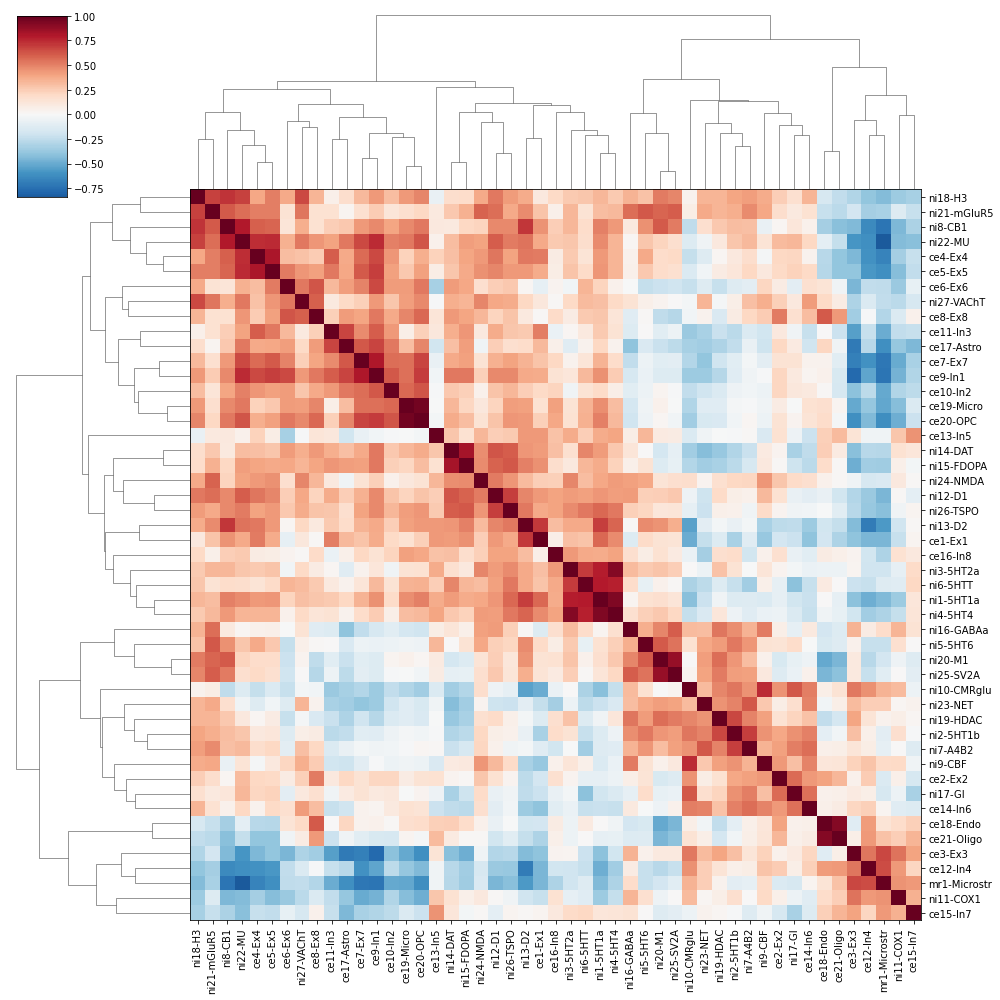

In [11]:
# predictor intercorrelation
temp = data_parc_destrieux.corr("spearman")
temp = rename_myelin(temp, "mr1-Microstr")
sns.clustermap(
    temp,
    center=0, 
    cmap="RdBu_r", 
    figsize=(14,14)
)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig(join(plot_dir, "predictor_correlation_destrieux.pdf"),  bbox_inches="tight")

### Brainplots

Context leak detected, msgtracer returned -1


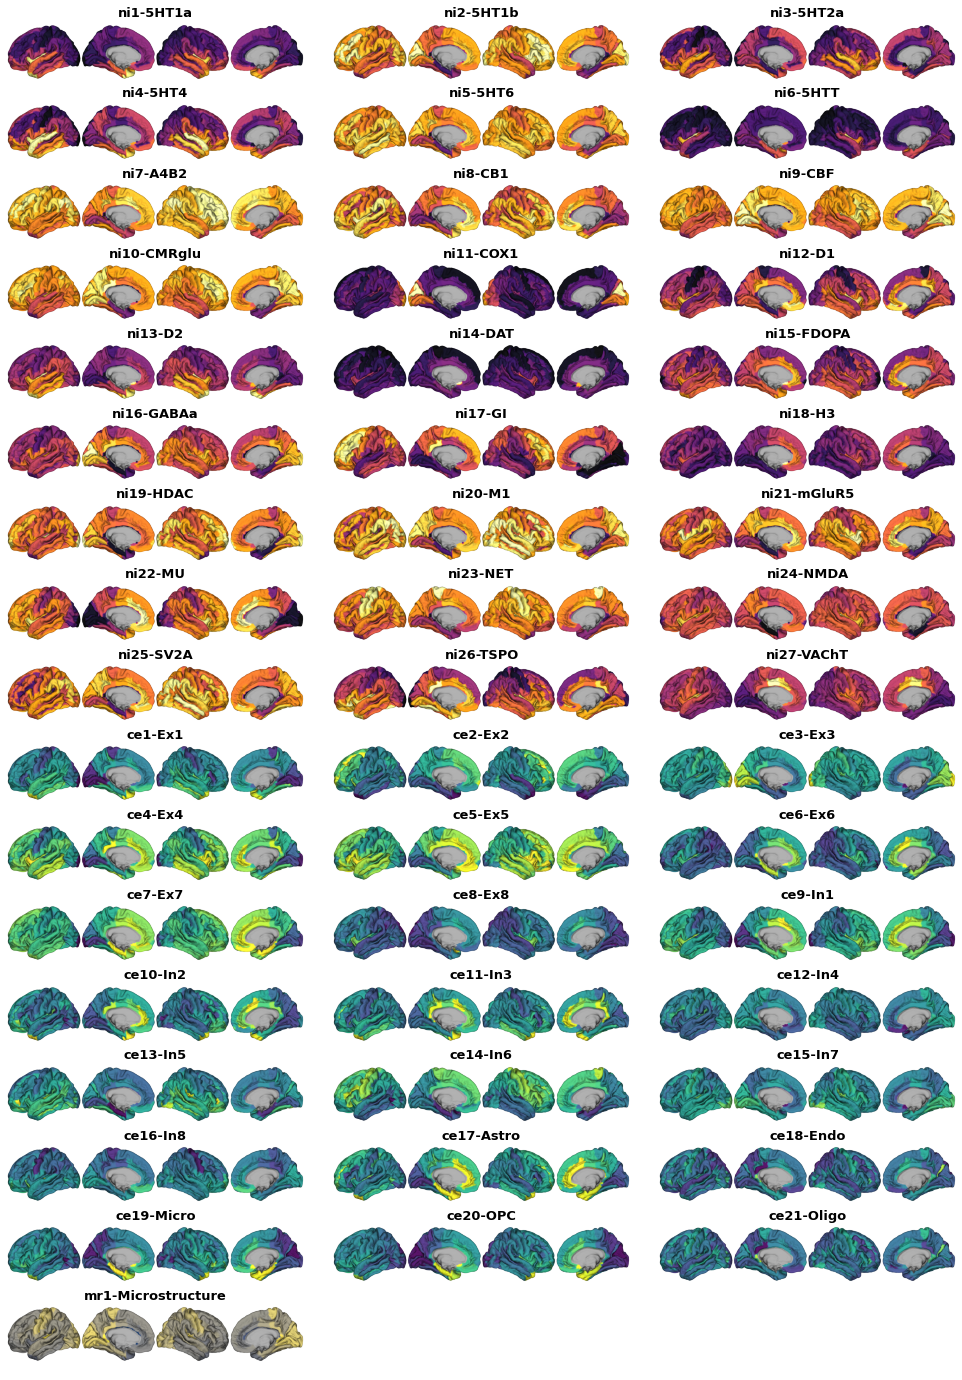

In [12]:
n_cols = 3
n_rows = int(np.ceil(len(data_parc_destrieux.columns)/n_cols)) 
fig, axes = plt.subplots(n_rows,n_cols, figsize=(17,25),
                         gridspec_kw=dict(hspace=0.05, wspace=0.1))
axes = axes.ravel()
for p, ax in zip(data_parc_destrieux, axes):
    lh, rh = get_parc_gifti(data_parc_destrieux[p])
    if p.startswith("ni"): c = "inferno"
    elif p.startswith("ce"): c = "viridis"
    else: c = "cividis"
    plot_surf_ax(ax=ax, fig=fig, lh=lh, rh=rh, c=c)
    ax.set_title(rename_myelin(p), weight="semibold", size=13)
[ax.axis("off") for ax in axes[len(data_parc_destrieux.columns):]]
    
fig.savefig(join(plot_dir, "predictor_brains.png"), dpi=200, bbox_inches="tight")

### Overview plot

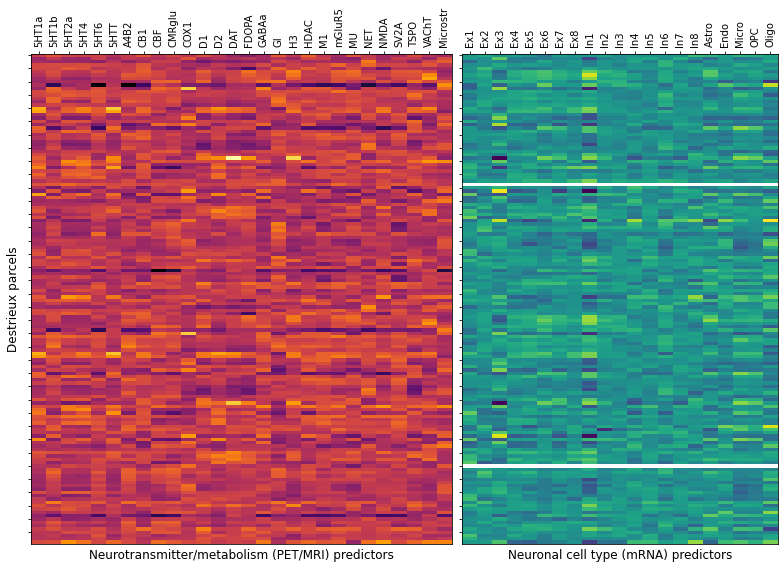

In [14]:
fig, axes = plt.subplots(1,2, figsize=(11,8), sharey=True, 
                         gridspec_kw=dict(width_ratios=(n_ni+1, n_cell)))

sns.heatmap(
    data=pd.concat(
        [pd.read_csv(join(predictor_dir, "ni_parc_destrieux.csv"), index_col=0), 
         pd.read_csv(join(predictor_dir, "mri_parc_destrieux.csv"), index_col=0).\
             rename(columns={"mr1-myelin":"Microstr"})], 
        axis=1
    ).iloc[:,:], 
    cbar=None, 
    ax=axes[0], 
    cmap="inferno"
)
axes[0].set_xticklabels(l.get_text().split("_")[0] for l in axes[0].get_xticklabels())
axes[0].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[0].set_ylabel("Destrieux parcels", size=12)
axes[0].set_xlabel("Neurotransmitter/metabolism (PET/MRI) predictors", size=12)

sns.heatmap(
    data=pd.read_csv(join(predictor_dir, "cell_parc_destrieux.csv"), index_col=0).iloc[:,:], 
    cbar=None, 
    ax=axes[1], 
    cmap="viridis"
)
_ = axes[1].set_yticklabels("")
axes[1].set_xticklabels(l.get_text().split("_")[0] for l in axes[1].get_xticklabels())
axes[1].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[1].set_xlabel("Neuronal cell type (mRNA) predictors", size=12)
fig.tight_layout()
sns.despine(top=False, right=False, left=False, bottom=False)

fig.savefig(join(plot_dir, "predictor_overview.pdf"), bbox_inches="tight")

## Dimensionality reduction based on factor analysis

In [15]:
# settings:
fa_method = "minres" # minimum residuals FA
rotation = "promax" # oblique rotation, factors should be allowed to correlate with each other
n_factor_select = "factor_ev" # select factor number based on total or factor-wise EV
n_factor_thresh = 0.01 # retain factors that explain > 1% of variance

### PET data

n = 10 factors with ev >= 1.0%


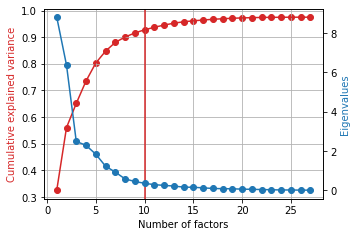

,ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC,ni2-5HT2a-5HT4-5HT1a-5HTT,ni3-FDOPA-DAT-D1-NMDA,ni4-GI-5HT1b-MU-A4B2,ni5-VAChT-NET,ni6-CBF-CMRglu,ni7-COX1,ni8-H3,ni9-D2,ni10-TSPO
eigenvalues,5.354676,4.020665,4.019465,2.814070,1.871108,1.798285,1.775084,1.201746,1.069707,0.621969
prop_variance,0.198321,0.148914,0.148869,0.104225,0.069300,0.066603,0.065744,0.044509,0.039619,0.023036
cum_variance,0.198321,0.347235,0.496104,0.600329,0.669629,0.736232,0.801976,0.846485,0.886104,0.909140


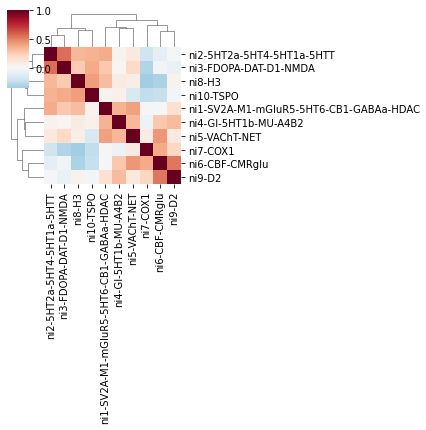

In [16]:
## Find factor number
fa = FactorAnalyzer(n_factors=n_ni, method=fa_method, rotation=None, svd_method="lapack")
fa.fit(ni_parc_destrieux)
# get eigenvalues & explained variance
eig,_ = fa.get_eigenvalues()
_, ev_frac, ev = fa.get_factor_variance()

# select n_factors based on overall explained variance
if n_factor_select=="total_ev":
    n_factors = [i for i in range(len(ev)) if (ev[i] >= n_factor_thresh)][1]
    print(f"n = {n_factors} factors explain >= {n_factor_thresh*100}% of variance")
# select n_factors based on factor-level explained variance
elif n_factor_select=="factor_ev":
    n_factors = [i+1 for i in range(len(ev_frac)) if (ev_frac[i] >= n_factor_thresh)][-1]
    print(f"n = {n_factors} factors with ev >= {n_factor_thresh*100}%")

# make scree plot
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(range(1, n_ni+1), ev, c="tab:red")
ax.scatter(range(1, n_ni+1), ev, c="tab:red")
ax2 = ax.twinx()
ax2.plot(range(1, n_ni+1), eig, c="tab:blue")
ax2.scatter(range(1, n_ni+1), eig, c="tab:blue")
ax.set_xlabel('Number of factors')
ax.set_ylabel('Cumulative explained variance', c="tab:red")
ax2.set_ylabel('Eigenvalues', c="tab:blue")
ax.axvline(n_factors, c="tab:red")
ax.grid()
plt.show()
plt.close()

## Run actual factor analysis
fa = FactorAnalyzer(n_factors=n_factors, method=fa_method, rotation=rotation, svd_method="lapack")
fa.fit(ni_parc_destrieux)
# get loadings and derive factor names
loadings = pd.DataFrame(fa.loadings_[:,:n_factors], index=ni_parc_destrieux.columns)
labels = dict()
pred_factor_idx = np.array([loadings.abs().loc[p,:].idxmax() for p in ni_parc_destrieux.columns])
pred_factor_val = np.array([loadings.abs().loc[p,:].max() for p in ni_parc_destrieux.columns])
labels = list()
nt_reordered = list()
for i in range(n_factors):
   labs = pd.Series(data=pred_factor_val[pred_factor_idx==i],
                    index=loadings.index[pred_factor_idx==i]).sort_values(ascending=False)
   nt_reordered += list(labs.index)
   labels.append(f"ni{i+1}-" + "-".join(labs.index))
loadings.columns = labels
# get factor scores
scores_destrieux = pd.DataFrame(
    fa.transform(ni_parc_destrieux)[:,:n_factors], 
    index=ni_parc_destrieux.index, 
    columns=labels)
# get explained variance
variance = pd.DataFrame(
    fa.get_factor_variance(), 
    index=["eigenvalues", "prop_variance", "cum_variance"], 
    columns=labels)
display(variance)

## save
fig.savefig(join(plot_dir, "dimred_ni_scree_destrieux.pdf"), bbox_inches="tight")
scores_destrieux.to_csv(join(predictor_dir, "ni_factors_destrieux.csv"))
loadings.to_csv(join(predictor_dir, "ni_factorloadings_destrieux.csv"))
variance.to_csv(join(predictor_dir, "ni_factorvariance_destrieux.csv"))

# check predictor intercorrelation
sns.clustermap(scores_destrieux.corr("spearman"), center=0, cmap="RdBu_r", figsize=(6,6))

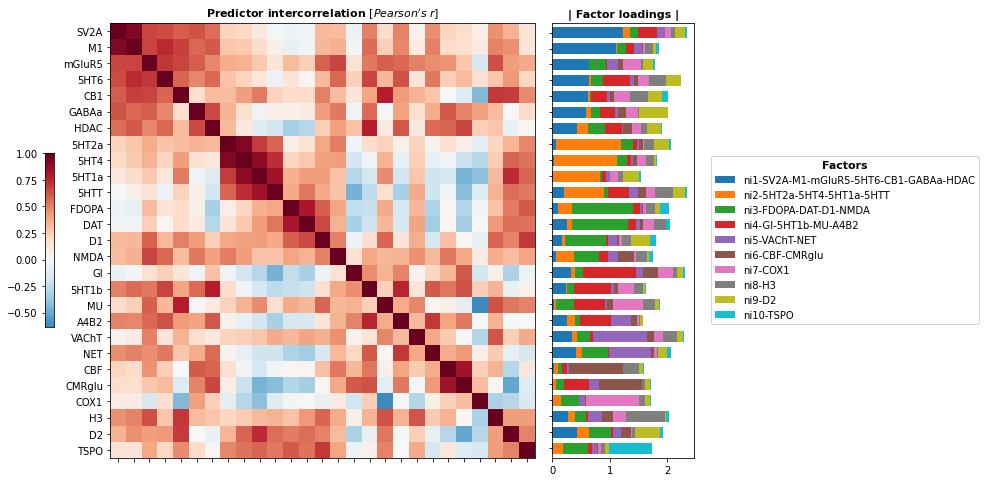

In [17]:
## Plot result

# figure
fig, axes = plt.subplots(1,2, figsize=(13,8), gridspec_kw=dict(width_ratios=(1,0.25), wspace=0.05))
# ax1: heatmap
sns.heatmap(
    ni_parc_destrieux[nt_reordered].corr(method="pearson"), 
    ax=axes[0], 
    center=0, 
    cmap="RdBu_r",
    cbar_kws=dict(location="left", pad=0.1, shrink=0.4))
axes[0].set_xticklabels("")
axes[0].set_title("Predictor intercorrelation $[Pearson's\ r]$", fontsize=11, fontweight="semibold")
# ax2: clustermap
ax = loadings.loc[nt_reordered[::-1],:].abs().plot(
    kind="barh", 
    stacked=True, 
    ax=axes[1],
    edgecolor=None,
    width=.7
    )
axes[1].set_yticklabels("")
axes[1].set_title("| Factor loadings |", fontsize=11, fontweight="semibold")
axes[1].legend(loc="center right", bbox_to_anchor=(3.05,0.5))\
    .set_title("Factors", prop=dict(size=11, weight="semibold"))
sns.despine(top=False, right=False, left=False, bottom=False)

# save
fig.savefig(join(plot_dir, "dimred_ni_loadings_destrieux.pdf"), bbox_inches="tight")

### Cell types

n = 10 factors with ev >= 1.0%


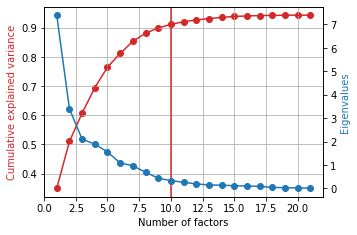

,ce1-Ex7-In4-Ex5-Ex4-In1,ce2-Oligo-Endo,ce3-Micro-OPC,ce4-In3-In2-Astro,ce5-In6-Ex2,ce6-Ex8-Ex6,ce7-In7-Ex3,ce8-In5,ce9-In8,ce10-Ex1
eigenvalues,3.268681,2.549259,2.517569,1.809356,1.782088,1.714052,1.357707,1.149069,1.069272,1.038342
prop_variance,0.155651,0.121393,0.119884,0.086160,0.084861,0.081622,0.064653,0.054718,0.050918,0.049445
cum_variance,0.155651,0.277045,0.396929,0.483089,0.567950,0.649572,0.714224,0.768942,0.819860,0.869304


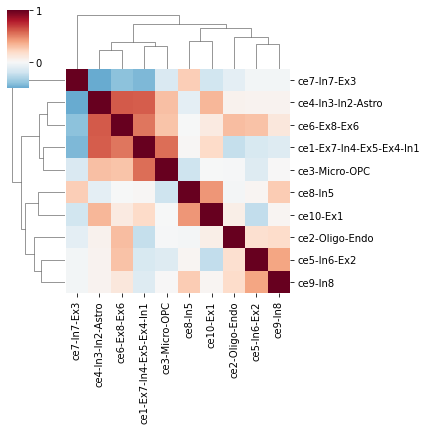

In [18]:
# drop NAs
cell_nan = list(cell_parc_destrieux[cell_parc_destrieux.isna().any(axis=1)].index)
cell_parc_destrieux_nan = cell_parc_destrieux.drop(cell_nan, axis=0)

## Find factor number
fa = FactorAnalyzer(n_factors=n_cell, method=fa_method, rotation=None)
fa.fit(cell_parc_destrieux_nan)
# get eigenvalues & explained variance
eig,_ = fa.get_eigenvalues()
_, ev_frac, ev = fa.get_factor_variance()

# select n_factors based on overall explained variance
if n_factor_select=="total_ev":
    n_factors = [i for i in range(len(ev)) if (ev[i] > n_factor_thresh)][1]
    print(f"n = {n_factors} factors explain >= {n_factor_thresh*100}% of variance")
# select n_factors based on factor-level explained variance
elif n_factor_select=="factor_ev":
    n_factors = [i+1 for i in range(len(ev_frac)) if (ev_frac[i] > n_factor_thresh)][-1]
    print(f"n = {n_factors} factors with ev >= {n_factor_thresh*100}%")

# make scree plot
fig, ax = plt.subplots(1, figsize=(5,3.5))
ax.plot(range(1, n_cell+1), ev, c="tab:red")
ax.scatter(range(1, n_cell+1), ev, c="tab:red")
ax2 = ax.twinx()
ax2.plot(range(1, n_cell+1), eig, c="tab:blue")
ax2.scatter(range(1, n_cell+1), eig, c="tab:blue")
ax.set_xlabel('Number of factors')
ax.set_ylabel('Cumulative explained variance', c="tab:red")
ax2.set_ylabel('Eigenvalues', c="tab:blue")
ax.axvline(n_factors, c="tab:red")
ax.grid()
plt.show()
plt.close()

## Run actual factor analysis
fa = FactorAnalyzer(n_factors=n_factors, method=fa_method, rotation=rotation, impute="drop")
fa.fit(cell_parc_destrieux_nan)
# get loadings and derive factor names
loadings = pd.DataFrame(fa.loadings_, index=cell_parc_destrieux.columns)
pred_factor_idx = np.array([loadings.abs().loc[p,:].idxmax() for p in cell_parc_destrieux.columns])
pred_factor_val = np.array([loadings.abs().loc[p,:].max() for p in cell_parc_destrieux.columns])
labels = list()
nt_reordered = list()
for i in range(n_factors):
    labs = pd.Series(data=pred_factor_val[pred_factor_idx==i],
                     index=loadings.index[pred_factor_idx==i]).sort_values(ascending=False)
    nt_reordered += list(labs.index)
    labels.append(f"ce{i+1}-" + "-".join(labs.index))
loadings.columns = labels
# get factor scores
scores_destrieux = fa.transform(cell_parc_destrieux_nan)
scores_destrieux = fill_nan(
    data=pd.DataFrame(scores_destrieux, index=cell_parc_destrieux_nan.index, columns=labels),
    idx=[list(cell_parc_destrieux.index).index(i) for i in cell_nan],
    idx_label=cell_nan,
    which="row")
# get explained variance
variance = pd.DataFrame(
    fa.get_factor_variance(), 
    index=["eigenvalues", "prop_variance", "cum_variance"], 
    columns=labels)
display(variance)

## save
fig.savefig(join(plot_dir, "dimred_cell_scree_destrieux.pdf"), bbox_inches="tight")
scores_destrieux.to_csv(join(predictor_dir, "cell_factors_destrieux.csv"))
loadings.to_csv(join(predictor_dir, "cell_factorloadings_destrieux.csv"))
variance.to_csv(join(predictor_dir, "cell_factorvariance_destrieux.csv"))

# check predictor intercorrelation
sns.clustermap(scores_destrieux.corr("spearman"), center=0, cmap="RdBu_r", figsize=(6,6))

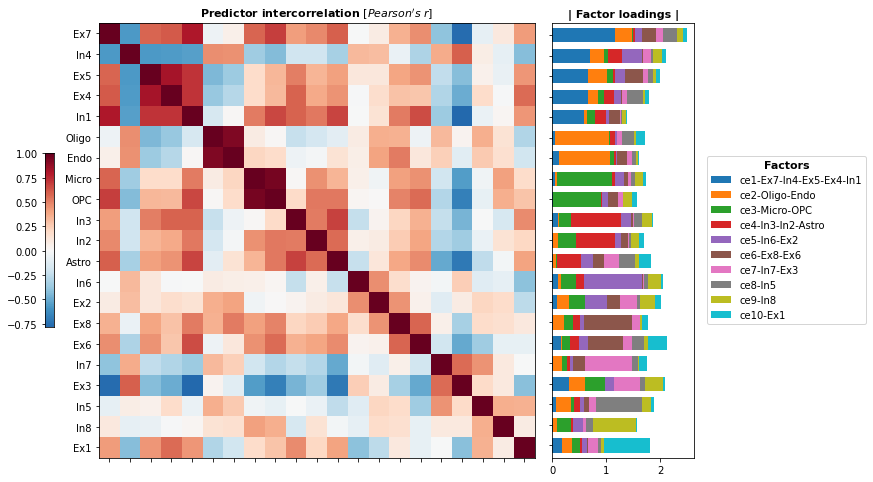

In [19]:
## Plot result

# figure
fig, axes = plt.subplots(1,2, figsize=(13,8), gridspec_kw=dict(width_ratios=(1,0.25), wspace=0.05))
# ax1: heatmap
sns.heatmap(
    cell_parc_destrieux[nt_reordered].corr(method="pearson"), 
    ax=axes[0], 
    center=0, 
    cmap="RdBu_r",
    cbar_kws=dict(location="left", pad=0.08, shrink=0.4))
axes[0].set_xticklabels("")
axes[0].set_title("Predictor intercorrelation $[Pearson's\ r]$", fontsize=11, fontweight="semibold")
# ax2: clustermap
loadings.loc[nt_reordered[::-1],:].abs().plot(
    kind="barh", 
    stacked=True, 
    ax=axes[1],
    edgecolor=None,
    width=.7
    )
axes[1].set_yticklabels("")
axes[1].set_title("| Factor loadings |", fontsize=11, fontweight="semibold")
axes[1].legend(loc="center right", bbox_to_anchor=(2.25,0.5))\
    .set_title("Factors", prop=dict(size=11, weight="semibold"))
sns.despine(top=False, right=False, left=False, bottom=False)

# save
fig.savefig(join(plot_dir, "dimred_cell_loadings_destrieux.pdf"), bbox_inches="tight")

## Collect predictors

In [20]:
data_scores_destrieux = pd.concat(
    [pd.read_csv(join(predictor_dir, "ni_factors_destrieux.csv"), index_col=0),
     pd.read_csv(join(predictor_dir, "cell_factors_destrieux.csv"), index_col=0),
     pd.read_csv(join(predictor_dir, "mri_parc_destrieux.csv"), index_col=0)],
    axis=1)
data_scores_destrieux.to_csv(join(predictor_dir, "data_factors_destrieux.csv"))
data_scores_destrieux.shape 

(148, 21)

### Intercorrelation

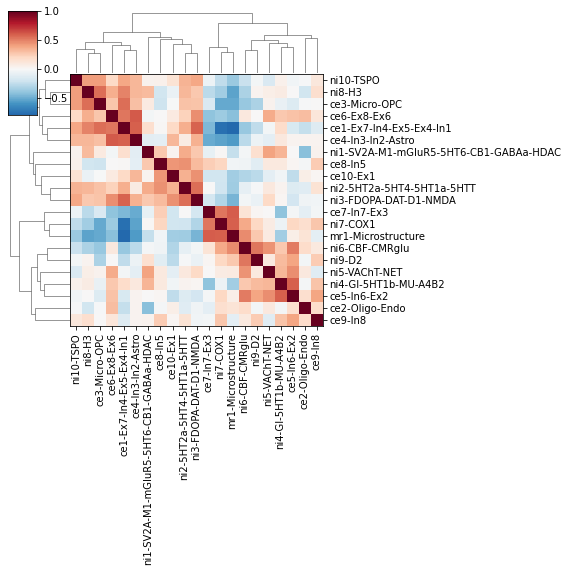

In [23]:
# predictor intercorrelation ni + cell
temp = data_scores_destrieux.corr("spearman")
temp = rename_myelin(temp)
sns.clustermap(temp,
               center=0, 
               cmap="RdBu_r", 
               figsize=(8,8))
sns.despine(top=False, right=False, left=False, bottom=False)
plt.savefig(join(plot_dir, f'dimred_factor_correlation_destrieux.pdf'),  bbox_inches='tight')

### Brainplots

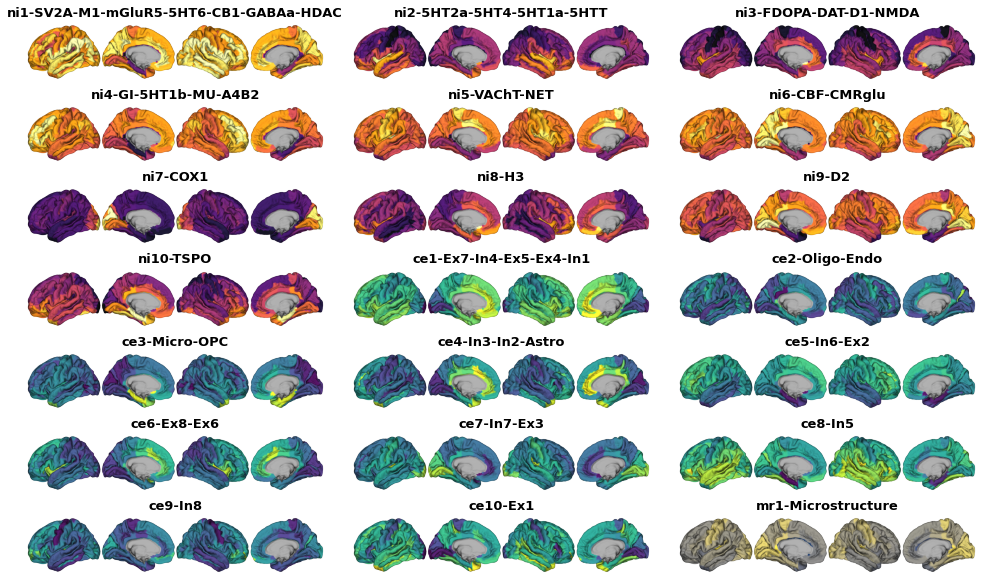

In [24]:
n_cols = 3
n_rows = int(np.ceil(len(data_scores_destrieux.columns)/n_cols)) 
fig, axes = plt.subplots(n_rows,n_cols, figsize=(17,10.5),
                         gridspec_kw=dict(hspace=0.05, wspace=0.1))
axes = axes.ravel()
for p, ax in zip(data_scores_destrieux, axes):
    lh, rh = get_parc_gifti(data_scores_destrieux[p])
    if p.startswith("ni"): c = "inferno"
    elif p.startswith("ce"): c = "viridis"
    else: c = "cividis"
    plot_surf_ax(ax=ax, fig=fig, lh=lh, rh=rh, c=c)
    ax.set_title(rename_myelin(p), weight="semibold", size=13)
[ax.axis("off") for ax in axes[len(data_scores_destrieux.columns):]]
    
fig.savefig(join(plot_dir, "dimred_predictor_brains.png"), dpi=200, bbox_inches="tight")

### Overview plot

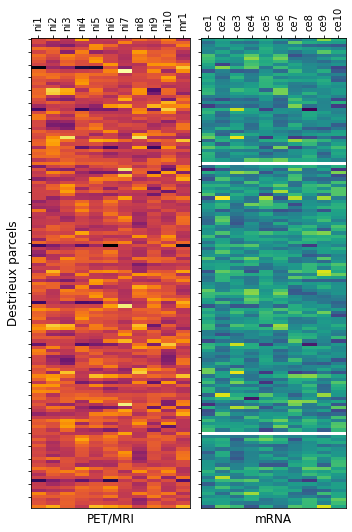

In [25]:
fig, axes = plt.subplots(1,2, figsize=(5,7.5), sharey=True, 
                         gridspec_kw=dict(width_ratios=(
                             len([c for c in data_scores_destrieux.columns if not c.startswith("ce")]), 
                             len([c for c in data_scores_destrieux.columns if c.startswith("ce")]))))

sns.heatmap(
    data=data_scores_destrieux[[c for c in data_scores_destrieux.columns if not c.startswith("ce")]], 
    cbar=None, 
    ax=axes[0], 
    cmap="inferno"
)
axes[0].set_xticklabels(l.get_text().split("-")[0] for l in axes[0].get_xticklabels())
axes[0].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[0].set_ylabel("Destrieux parcels", size=12)
axes[0].set_xlabel("PET/MRI", size=12)

sns.heatmap(
    data=data_scores_destrieux[[c for c in data_scores_destrieux.columns if c.startswith("ce")]], 
    cbar=None, 
    ax=axes[1], 
    cmap="viridis"
)
_ = axes[1].set_yticklabels("")
axes[1].set_xticklabels(l.get_text().split("-")[0] for l in axes[1].get_xticklabels())
axes[1].tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, 
                    top=True, labeltop=True, rotation=90)
axes[1].set_xlabel("mRNA", size=12)
fig.tight_layout()
sns.despine(top=False, right=False, left=False, bottom=False)

fig.savefig(join(plot_dir, "dimred_predictor_overview.pdf"), bbox_inches="tight")

## Validation of factor analysis explained variance

### Generate null maps

In [26]:
nice_parc_nulls, dist_mat = generate_null_maps(
    data=zscore(pd.concat([ni_parc_destrieux, cell_parc_destrieux], axis=1).T, nan_policy="omit"),
    parcellation=parc_destrieux,
    parc_space="fsaverage",
    parc_hemi=["L", "R"], 
    parc_density="10k",
    n_nulls=n_perm,
    seed=42,
    n_cores=-1
)

# These lines would pickle the null maps but the file would be about 500Mb so we regenerate it
# import pickle
# import gzip
# with gzip.open(join(predictor_dir, "null_factors_destrieux.pkl.gz"), "wb") as f:
#     pickle.dump(nice_parc_nulls, f, pickle.HIGHEST_PROTOCOL)

INFO: Null map generation: Assuming n = 48 data vector(s) for n = 148 parcels.
INFO: Loaded parcellation (parc_space = 'fsaverage', parc_hemi = ['L', 'R'], parc_density = '10k').
INFO: Calculating distance matrix/matrices (geodesic).


Generating null maps (-1 proc):   0%|          | 0/48 [00:00<?, ?it/s]

### Test if EV higher in FA trained on observed as compared to null data

ni
Observed total EV = 0.9091398721158839


  0%|          | 0/10000 [00:00<?, ?it/s]

p = 0.03169999999999995


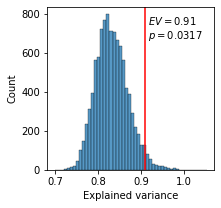

ce
Observed total EV = 0.8693044865564958


  0%|          | 0/10000 [00:00<?, ?it/s]

p = 0.04949999999999999


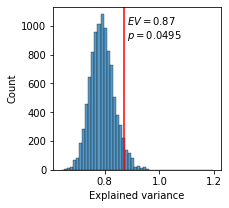

In [27]:
# iterate nuclear imaging and cell predictors
for modality, parc_df in zip(["ni", "ce"], [ni_parc_destrieux, cell_parc_destrieux]):
    print(modality)
    
    # data
    idx_nonan = parc_df.notna().any(axis=1)
    parc_df = zscore(parc_df[idx_nonan])
    n_factors = len([c for c in data_scores_destrieux if c.startswith(modality)])
    predictors = parc_df.columns.to_list()
    var_data = np.var(parc_df, axis=0).sum()
    
    # FA object
    fa = FactorAnalyzer(n_factors=n_factors, method=fa_method, 
                        rotation=rotation, svd_method="lapack")
    # fit on observed data
    fa.fit(parc_df)
    # observed explained variance
    loadings_obs = fa.loadings_
    variance_obs = np.sum(loadings_obs**2, axis=0)
    ev_obs = np.sum(variance_obs / var_data)
    print("Observed total EV =", ev_obs)    
    
    # function that returns explained variance in original data after fitting on permuted data
    def par_fun(data):
        # fit on null data
        fa.fit(zscore(data))
        # explained variance as proportion to un-permuted df
        loadings_null = fa.loadings_
        variance_null = np.sum(loadings_null**2, axis=0)
        ev_null = np.sum(variance_null / var_data)
        return ev_null
    
    # null explained variance
    ev_null = Parallel(-1)(
        delayed(par_fun)
        (pd.DataFrame([nice_parc_nulls[p][i][idx_nonan] \
            for p in predictors]).T) for i in tqdm(range(n_perm))
    )

    # p
    p_obs = null_to_p(ev_obs, ev_null, tail="upper")
    print("p =", p_obs)
    
    # plot
    fig, ax = plt.subplots(1, figsize=(3,3))
    sns.histplot(ev_null, bins=50, ax=ax)
    ax.axvline(ev_obs, c="r")
    ax.text(
        s=f"$EV = {ev_obs:.02f}$\n$p = {p_obs:.04f}$", 
        x=ev_obs + np.abs(np.subtract(*ax.get_xlim())) / 50, 
        y=ax.get_ylim()[1] * 0.95, 
        ha="left", va="top"
    )
    ax.set_xlabel("Explained variance")
    ax.set_ylabel("Count")
    fig.savefig(join(plot_dir, f"dimred_{modality}_permutation.pdf"), bbox_inches="tight")
    plt.show()

## Stability of PET map ranks (across age)

### Load PET data

In [28]:
## pet map info (nistab = stability of neuroimaging results)
nistab_files_info = pd.read_csv(join(predictor_dir, "pet", "pet_maps_stability.csv"))
nistab_files_info = nistab_files_info.sort_values("age")
# all files
nistab_files = nistab_files_info.atlas_file.to_list()
# files that are in main analysis
nistab_files_main = [f for f in nistab_files if f in ni_files]

## load data and transform to surface

# initialize parcellater
parcellater_destrieux = parcellate.Parcellater(
    parcellation=parc_destrieux, 
    space="fsaverage", 
    resampling_target="parcellation"
).fit()

# iterate pet data
ni_stab_parc_destrieux = np.zeros((len(destrieux_idps), len(nistab_files)))

for i, ni_file in enumerate(nistab_files):
    print(i, ni_file)
    
    # get image
    pet = images.load_nifti(join(predictor_dir, "pet", ni_file))
    # mni152-surface transform
    pet_fsa, _ = resampling.resample_images(
        src=pet, 
        src_space="mni152", 
        trg=parc_destrieux, 
        trg_space="fsaverage", 
        method="linear", 
        resampling="transform_to_trg"
    )  
    # parcellate
    ni_stab_parc_destrieux[:,i] = zscore(
        parcellater_destrieux.transform(pet_fsa, 'fsaverage'), 
        axis=0, 
        nan_policy="omit"
        )
    
# to dataframe & csv
ni_stab_parc_destrieux = pd.DataFrame(
    ni_stab_parc_destrieux, 
    columns=nistab_files,
    index=destrieux_idps
)
ni_stab_parc_destrieux.to_csv(join(predictor_dir, 'nistab_parc_destrieux.csv'))
ni_stab_parc_destrieux

0 mGluR5-abp688-73-smart2019.nii.gz
1 mGluR5-abp688-13-kaulen2022.nii.gz
2 D2-flb457-55-sandiego2015.nii.gz
3 mGluR5-abp688-28-dubois2015.nii.gz
4 VAChT-feobv-4-tuominen.nii.gz
5 D2-flb457-37-smith2019.nii.gz
6 VAChT-feobv-18-aghourian2017.nii.gz
7 mGluR5-abp688-22-rosaneto.nii.gz


,mGluR5-abp688-73-smart2019.nii.gz,mGluR5-abp688-13-kaulen2022.nii.gz,D2-flb457-55-sandiego2015.nii.gz,mGluR5-abp688-28-dubois2015.nii.gz,VAChT-feobv-4-tuominen.nii.gz,D2-flb457-37-smith2019.nii.gz,VAChT-feobv-18-aghourian2017.nii.gz,mGluR5-abp688-22-rosaneto.nii.gz
lh_G&S_frontomargin_thickness,-0.696604,-0.503583,0.001725,-0.026390,-0.057870,-0.429224,-0.122353,0.820284
lh_G&S_occipital_inf_thickness,-1.046121,-0.620926,-0.400126,-0.734019,-1.104403,-0.306700,-1.035968,-0.370450
lh_G&S_paracentral_thickness,-0.895742,-2.233430,-1.307145,-1.367093,0.590735,-1.189648,0.534480,-1.108118
lh_G&S_subcentral_thickness,1.475174,0.281303,0.049931,1.263954,0.610511,0.044048,1.048199,1.121270
lh_G&S_transv_frontopol_thickness,-0.559114,-0.372754,-0.402673,-0.016855,0.038935,-0.389713,-0.579973,0.567977
...,...,...,...,...,...,...,...,...
rh_S_suborbital_thickness,1.374919,1.277894,0.241071,1.676437,0.452489,0.021998,-0.125262,1.979540
rh_S_subparietal_thickness,0.908847,0.663623,-0.566368,1.035104,-0.138030,-0.614791,0.441915,1.092944
rh_S_temporal_inf_thickness,0.138196,0.416913,0.934770,0.119697,-0.471208,1.052302,-0.700534,-0.299554
rh_S_temporal_sup_thickness,0.777682,0.983369,0.298125,0.425571,-0.145107,0.605039,-0.367064,0.254284


### Evaluate and plot

mGluR5-abp688-73-smart2019.nii.gz ['mGluR5-abp688-13-kaulen2022.nii.gz', 'mGluR5-abp688-28-dubois2015.nii.gz', 'mGluR5-abp688-22-rosaneto.nii.gz']


Context leak detected, msgtracer returned -1


D2-flb457-55-sandiego2015.nii.gz ['D2-flb457-37-smith2019.nii.gz']
VAChT-feobv-18-aghourian2017.nii.gz ['VAChT-feobv-4-tuominen.nii.gz']


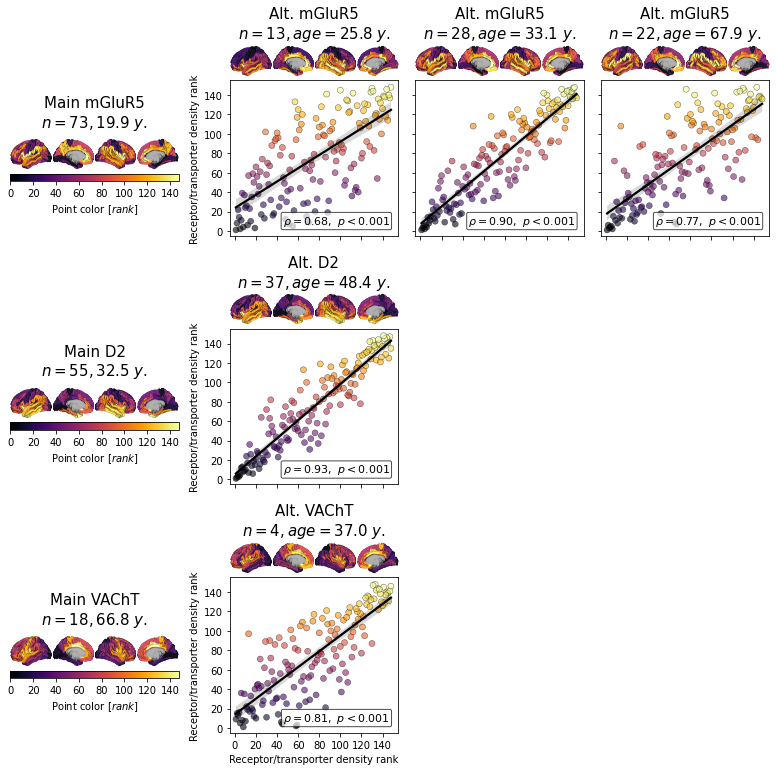

In [29]:
fig, axes = plt.subplots(len(nistab_files_main), 4, figsize=(13,12), sharey=False, sharex=True,
                         gridspec_kw=dict(hspace=0.6, wspace=0.1))

for r, pred in enumerate(nistab_files_main):
    
    # data
    y = rankdata(ni_stab_parc_destrieux[pred])
    
    # maps with same target system, exclude iterated map
    nistab_files_target = [p for p in nistab_files if (p != pred) & p.startswith(pred.split("-")[0])]
    print(pred, nistab_files_target)
    
    # brain subplot
    lh, rh = get_parc_gifti(y)
    ax_brain = axes[r,0].inset_axes((-0.2, 0.4, 1, 0.25))
    plot_surf_ax(ax=ax_brain, fig=fig, lh=lh, rh=rh, c="inferno")
    fig.colorbar(
        cm.ScalarMappable(norm=Normalize(0,148), cmap="inferno"), 
        cax=axes[r,0].inset_axes((-0.2, 0.35, 1, 0.05)),
        orientation="horizontal",
        
        ticks=range(0,141,20),
        label="Point color $[rank]$"
    )
    
    # label
    axes[r,0].annotate(
        f"Main {pred.split('-')[0]}\n"
        f"$n = {pred.split('-')[2]}, $"
        f"${nistab_files_info.loc[nistab_files_info.atlas_file==pred, 'age'].values[0]}\ y.$", 
        xy=(0.3,0.7), xycoords="axes fraction", ha="center",
        size=15
    )
    
    for c, pred_target in enumerate(nistab_files_target, start=1):
        
        # data
        x = rankdata(ni_stab_parc_destrieux[pred_target])
        
        # scatterplot
        sns.scatterplot(y=y, x=x, ax=axes[r,c], hue=y, palette="inferno", legend=None, alpha=0.6, ec="k")
        sns.regplot(y=y, x=x, ax=axes[r,c], scatter=False, color="k")
        axes[r,c].set_title(
            f"Alt. {pred_target.split('-')[0]}\n"
            f"$n = {pred_target.split('-')[2]}, $"
            f"$age = {nistab_files_info.loc[nistab_files_info.atlas_file==pred_target, 'age'].values[0]}\ y.$",            
            size=15
        )
        axes[r,c].set_xlim(-5,155)
        axes[r,c].set_xticks(range(0,141,20))
        axes[r,c].set_ylim(-5,155)
        axes[r,c].set_yticks(range(0,141,20))
        axes[r,c].set_yticklabels([])
        if c==1:
            axes[r,c].set_ylabel("Receptor/transporter density rank")
            axes[r,c].set_yticklabels(range(0,141,20))
        if r==axes.shape[0]-1:
            axes[r,c].set_xlabel("Receptor/transporter density rank")
            
        # stats        
        spear = spearmanr(x, y)
        axes[r,c].annotate(
            r"$\rho$" + f"$= {spear[0]:.02f},\ p {'=' + str(spear[1].round(3)) if spear[1] >= 0.001 else '< 0.001'}$",
            xy=(0.95,0.05),
            xycoords="axes fraction",
            ha="right",
            va="bottom",
            size=11,
            bbox=dict(boxstyle="round,pad=0.15", fc="w", alpha=0.7)
        )
        
        # brain subplot
        lh, rh = get_parc_gifti(x)
        ax_brain = axes[r,c].inset_axes((0, 1, 1, 0.25))
        plot_surf_ax(ax=ax_brain, fig=fig, lh=lh, rh=rh, c="inferno")

            
    # empty axes
    [axes[r,c].set_axis_off() for c in [0] + list(range(c+1, 4))]

fig.savefig(join(plot_dir, "predictor_age_stability.pdf"), bbox_inches="tight", dpi=300)